# Attention

In [162]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

In [163]:
SEED=1337

In [164]:
#we'll define a set of seeds and make it reproducible
def set_seeds(seed=1337):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        eval("setattr(torch.backends.cudnn, 'deterministic', True)")
        eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)   
set_seeds(SEED)

In [219]:
#set device
def set_device():
  if torch.backends.mps.is_available():
    device=torch.device("mps")
  elif torch.cuda.is_available():
    device=torch.device("cuda")
  else:
    device=torch.device("cpu")
  #for now we're just going to be on cpu because torch 2.0.0 has problems with mps backend
  return torch.device('cpu')
  return device
device=set_device()
print(f"Using device: {device}")
torch.set_default_device(device)

Using device: cpu


#### Load data

In [166]:
# import subprocess
# subprocess.Popen('python3.10 pip install kaggle', shell=True)
# subprocess.Popen('kaggle datasets download -d amananandrai ag-news-classification-dataset unzip ag-news-classification-dataset.zip', shell=True)


In [167]:
#Load data
#loation

df=pd.concat([pd.read_csv('train.csv', header=0), pd.read_csv('test.csv', header=0)])
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,Class Index,Title,Description
0,3,NAB turnaround to take time,"National Australia Bank, despite reporting a h..."
1,4,Microsoft Files More Spam Suits,New lawsuits include one against a Web hosting...
2,2,"Canadian Allenby, NCAA champion Moore advance ...","MAMARONECK, NY (CP) - NCAA champion Ryan Moore..."
3,3,Stocks Seen Higher Before Jobs Data,NEW YORK (Reuters) - U.S. stock futures surge...
4,4,Massive Merger of Galaxies is the Most Powerfu...,Scientists have now officially witnessed the p...


In [168]:
df['Class Index'].unique()

array([3, 4, 2, 1])

#### Cleaning

In [169]:
import nltk 
# to get rid of common words that dont hold much meaning
from nltk.corpus import stopwords
# to get rid of words that have common suffixes
from nltk.stem import PorterStemmer
import re

In [170]:
nltk.download('stopwords')
STOPWORDS=stopwords.words('english')
print(STOPWORDS[:5])
PORTER=PorterStemmer()

['a', 'about', 'above', 'after', 'again']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marcwolpert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [171]:
def preprocess(text,stopwords=STOPWORDS):
  #lower
  text=text.lower()
  #remove punctuation
  pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
  text=pattern.sub('',text)

  #remove words in parentheses
  text = re.sub(r"\([^)]*\)", "", text)

  #spacing and filters
  text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
  text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
  text = re.sub(" +", " ", text)  # remove multiple spaces
  text = text.strip()

  return text

text='Great week for the NYSE'
print(preprocess(text))

great week nyse


In [172]:
#apply to all text
preprocessed_df=df.copy()
preprocessed_df['Title']=preprocessed_df['Title'].apply(preprocess)
print(f"{df['Title'].values[0]}\n\n{preprocessed_df['Title'].values[0]}")
#tokenize

NAB turnaround to take time

nab turnaround take time


#### Note:
- Applying these preprocessing steps (like standardization) has to be separate from the training/test data. This is because we cannot apply any knowledge gained from the test set accidentally (data leak) during preprocessing/training. However for global preprocessing steps like the function above, we aren't learning anything from the data itself, and so we can apply it to all the data.

### Split the data

In [173]:
import collections
from sklearn.model_selection import train_test_split

TRAIN_SIZE=0.7
TEST_SIZE=0.15
VAL_SIZE=0.15

def train_val_test_split(X,y,train_size):
  #split the data
  X_train,X_, y_train,y_=train_test_split(X,y,train_size=TRAIN_SIZE,stratify=y)
  X_val,X_test,y_val,y_test=train_test_split(X_,y_,test_size=0.5,stratify=y_)
  return X_train,X_val,X_test,y_train,y_val,y_test

X=preprocessed_df['Title']
y=preprocessed_df['Class Index']
X_train,X_val,X_test,y_train,y_val,y_test=train_val_test_split(X,y,TRAIN_SIZE)

In [174]:
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (89320,), y_train: (89320,)
X_val: (19140,), y_val: (19140,)
X_test: (19140,), y_test: (19140,)
Sample point: nab turnaround take time → 3


### Turning our text labels into unique indices

In [175]:
import itertools
import json

Note: the @classmethod is a decorator that bind to the class and not the instance.

In [176]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        # Make a brand-new dict with plain Python ints as keys:
        serializable = {int(k): v for k, v in self.class_to_index.items()}

        with open(fp, "w") as out_f:
            json.dump({"class_to_index": serializable}, out_f, indent=4, sort_keys=False)


    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)


In [177]:
#Encode
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
label_encoder.save("label_encoder.json")
NUM_CLASSES = len(label_encoder)
label_encoder.class_to_index

{1: 0, 2: 1, 3: 2, 4: 3}

In [178]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: 3
y_train[0]: 0


In [179]:
#class weights
counts=np.bincount(y_train)
class_weights={i: 1.0/count for i, count in enumerate(counts)}
print(f"counts:{counts}\nweights:{class_weights}")

counts:[22330 22330 22330 22330]
weights:{0: 4.478280340349306e-05, 1: 4.478280340349306e-05, 2: 4.478280340349306e-05, 3: 4.478280340349306e-05}


#### Tokenizer
- Now to convert our text into tokens.

In [180]:
import json
from collections import Counter
from more_itertools import take

In [181]:
class Tokenizer(object):
    def __init__(self, char_level, num_tokens=None,
                 pad_token="<PAD>", oov_token="<UNK>",
                 token_to_index=None):
        self.char_level = char_level
        self.separator = "" if self.char_level else " "
        if num_tokens: num_tokens -= 2 # pad + unk tokens
        self.num_tokens = num_tokens
        self.pad_token = pad_token
        self.oov_token = oov_token
        if not token_to_index:
            token_to_index = {pad_token: 0, oov_token: 1}
        self.token_to_index = token_to_index
        self.index_to_token = {v: k for k, v in self.token_to_index.items()}

    def __len__(self):
        return len(self.token_to_index)

    def __str__(self):
        return f"<Tokenizer(num_tokens={len(self)})>"

    def fit_on_texts(self, texts):
        if not self.char_level:
            texts = [text.split(" ") for text in texts]
        all_tokens = [token for text in texts for token in text]
        counts = Counter(all_tokens).most_common(self.num_tokens)
        self.min_token_freq = counts[-1][1]
        for token, count in counts:
            index = len(self)
            self.token_to_index[token] = index
            self.index_to_token[index] = token
        return self

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            if not self.char_level:
                text = text.split(" ")
            sequence = []
            for token in text:
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]))
            sequences.append(np.asarray(sequence))
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for index in sequence:
                text.append(self.index_to_token.get(index, self.oov_token))
            texts.append(self.separator.join([token for token in text]))
        return texts

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {
                "char_level": self.char_level,
                "oov_token": self.oov_token,
                "token_to_index": self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

#### Warning:
- It's importand to only fit using our train data split because during inference, our model will not always know every token so it's important to replicate that scenario with our validation and test splits as well.

In [182]:
#Tokenize
tokenizer=Tokenizer(char_level=False,num_tokens=5000)
tokenizer.fit_on_texts(X_train)
tokenizer.save("tokenizer.json")
print(len(tokenizer))
VOCAB_SIZE=len(tokenizer)
print(tokenizer)

5000
<Tokenizer(num_tokens=5000)>


In [183]:
#sample of tokens
print(take(5,tokenizer.token_to_index.items()))
print(f"least freq token's freq: {tokenizer.min_token_freq}")

[('<PAD>', 0), ('<UNK>', 1), ('39', 2), ('b', 3), ('gt', 4)]
least freq token's freq: 15


In [184]:
# Convert texts to sequences of indices
X_train = tokenizer.texts_to_sequences(X_train)
print(len(X_train))
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)
print(f"X_train[0:5]: {X_train[0:5]}")
preprocessed_text = tokenizer.sequences_to_texts([X_train[0]])[0]
print ("Text to indices:\n"
    f"  (preprocessed) → {preprocessed_text}\n"
    f"  (tokenized) → {X_train[0]}")

89320
X_train[0:5]: [array([ 454, 4192,  256,    1,  543,   22]), array([2596, 1106,  822,  232,  855,  634]), array([ 455, 1027, 2160, 2483,  911,   90, 1459]), array([1674, 1615,    2, 2860,   89, 1675,  505,    2, 2861,    1,    2,
          5,    3,    4,    5,    3,    4]), array([   1,  438,  383,  166, 3760,   15, 2484])]
Text to indices:
  (preprocessed) → putin recent attacks <UNK> hurt bush
  (tokenized) → [ 454 4192  256    1  543   22]


#### Padding
- Since this is a sequence model, we have to pad our sequences to the same length.

In [185]:
def pad_sequences(sequences,max_seq_len=0):
  """Pad sequences to max length in sequence"""
  max_seq_len=max(max_seq_len,max(len(sequence) for sequence in sequences))
  padded_sequences=np.zeros((len(sequences),max_seq_len))
  for i,seq in enumerate(sequences):
    padded_sequences[i][:len(seq)]=seq
  return padded_sequences

In [186]:
#2D sequences
padded=pad_sequences(X_train[0:3])
print(padded.shape)
print(padded)

(3, 7)
[[4.540e+02 4.192e+03 2.560e+02 1.000e+00 5.430e+02 2.200e+01 0.000e+00]
 [2.596e+03 1.106e+03 8.220e+02 2.320e+02 8.550e+02 6.340e+02 0.000e+00]
 [4.550e+02 1.027e+03 2.160e+03 2.483e+03 9.110e+02 9.000e+01 1.459e+03]]


#### Datasets/Dataloaders

- Need to create datasets/dataloaders to be able to efficiently create batches with our batch splits.

In [187]:
import torch
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, len(X), y]

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        batch = np.array(batch,dtype=object)
        X = batch[:, 0]
        seq_lens = batch[:, 1]
        y = batch[:, 2]

        # Pad inputs
        X = pad_sequences(sequences=X)

        # Cast to same data type for processing
        X = torch.LongTensor(X.astype(np.int32))
        seq_lens = torch.LongTensor(seq_lens.astype(np.int32))
        y = torch.LongTensor(y.astype(np.int32))

        return X, seq_lens, y

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        dl=torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle, drop_last=drop_last, pin_memory=True)
        return dl


- We create datasets/dataloaders to be able to efficiently create batches with our batch splits.
- For huge datasets, this process is done so that we avoid the OOM error and to only keep the data in memory that we need for the current batch.

In [188]:
#create datasets
train_dataset=Dataset(X_train,y_train)
val_dataset=Dataset(X_val,y_val)
test_dataset=Dataset(X_test,y_test)
#create dataloaders
print(f"Datasets:\nTrain: {train_dataset.__str__()}\nVal: {val_dataset.__str__()}\nTest: {test_dataset.__str__()}")
print(f"Samples:\nTrain: {train_dataset[0][0]}")
print(f"Sequence lengths:{train_dataset[0][1]}")
print(f"y: {train_dataset[0][2]}")

Datasets:
Train: <Dataset(N=89320)>
Val: <Dataset(N=19140)>
Test: <Dataset(N=19140)>
Samples:
Train: [ 454 4192  256    1  543   22]
Sequence lengths:6
y: 0


In [189]:
# Create dataloaders
batch_size = 32
train_dataloader = train_dataset.create_dataloader(
    batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(
    batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(
    batch_size=batch_size)
batch_X, batch_seq_lens, batch_y = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  seq_lens: {list(batch_seq_lens.size())}\n"
    f"  y: {list(batch_y.size())}\n"
    "Sample point:\n"
    f"  X: {batch_X[0]}\n"
    f" seq_len: {batch_seq_lens[0]}\n"
    f"  y: {batch_y[0]}")

Sample batch:
  X: [32, 17]
  seq_lens: [32]
  y: [32]
Sample point:
  X: tensor([ 454, 4192,  256,    1,  543,   22,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0])
 seq_len: 6
  y: 0


In [190]:
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):

        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0

        # Iterate over train batches
        for i, batch in enumerate(dataloader):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)

        return loss

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)

                # Store outputs
                y_prob = torch.sigmoid(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Forward pass w/ inputs
                inputs, targets = batch[:-1], batch[-1]
                y_prob = F.softmax(self.model(inputs), dim=1)

                # Store outputs
                y_probs.extend(y_prob)

        return np.vstack(y_probs)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            # Steps
            train_loss = self.train_step(dataloader=train_dataloader)
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            # Logging
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}, "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
        return best_model

#### Attention

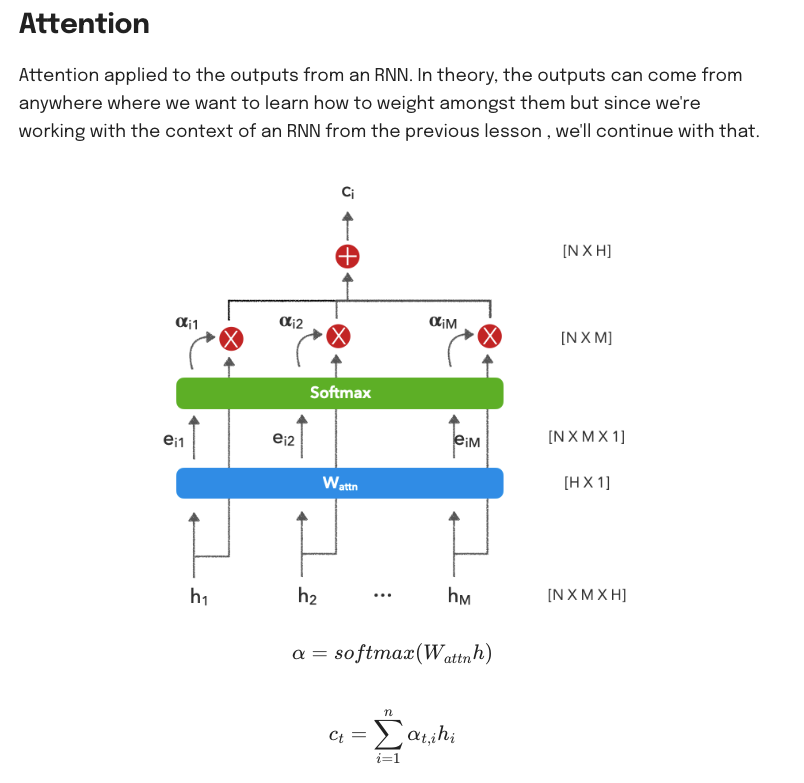


We're going to create an RNN with an encoded representation for each word in our input resulting in a stacked vector that has dimensions N x M x H, where:
- N = batch size
- M = max sequence length of the batch
- H = hidden size of the RNN

In [191]:
BATCH_SIZE=32
SEQ_LEN=8
# this is the vector input dimension
EMBEDDING_DIM=100
# this is the hidden dimension between RNN cells
RNN_HIDDEN_DIM=128

In [192]:
#embed
x=torch.rand((BATCH_SIZE,SEQ_LEN,EMBEDDING_DIM))
#encode
rnn=nn.RNN(EMBEDDING_DIM,RNN_HIDDEN_DIM,batch_first=True)
out,h_n=rnn(x) #h_n is the last hidden state
print(f"Out: {out.shape}")
print(f"h_n: {h_n.shape}")

Out: torch.Size([32, 8, 128])
h_n: torch.Size([1, 32, 128])


Here comes the attention mechanism.

In [193]:
#attend
attn=nn.Linear(RNN_HIDDEN_DIM,1)
e=attn(out) 
attn_vals=F.softmax(e.squeeze(2),dim=1)
#does the attention mechanism to the outputs and makees the 
#dimensions the same, then makes them a vector again
c=torch.bmm(attn_vals.unsqueeze(1),out).squeeze(1)

print ("e: ", e.shape)
print ("attn_vals: ", attn_vals.shape)
print ("attn_vals[0]: ", attn_vals[0])
print ("sum(attn_vals[0]): ", sum(attn_vals[0]))
#result of the intermediary attention step to this RNN cell
print ("c: ", c.shape)

e:  torch.Size([32, 8, 1])
attn_vals:  torch.Size([32, 8])
attn_vals[0]:  tensor([0.1339, 0.1303, 0.1315, 0.1281, 0.1078, 0.1331, 0.1217, 0.1135],
       grad_fn=<SelectBackward0>)
sum(attn_vals[0]):  tensor(1.0000, grad_fn=<AddBackward0>)
c:  torch.Size([32, 128])


In [194]:
#Predict
fc1=nn.Linear(RNN_HIDDEN_DIM,NUM_CLASSES)
output=F.softmax(fc1(c),dim=1)
print(f"Output: {output.shape}")

Output: torch.Size([32, 4])


### Now to actually implement the RNN based model but with the addition of attention layer on top of the RNN's output.

In [195]:
RNN_HIDDEN_DIM=128
DROPOUT_P=0.1
HIDDEN_DIM=100

In [196]:
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, rnn_hidden_dim,
                 hidden_dim, dropout_p, num_classes, padding_idx=0):
        super(RNN, self).__init__()

        # Initialize embeddings
        self.embeddings = nn.Embedding(
            embedding_dim=embedding_dim, num_embeddings=vocab_size,
            padding_idx=padding_idx)

        # RNN
        self.rnn = nn.RNN(embedding_dim, rnn_hidden_dim, batch_first=True)

        # Attention
        self.attn = nn.Linear(rnn_hidden_dim, 1)

        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs):
        # Embed
        x_in, seq_lens = inputs
        x_in = self.embeddings(x_in)

        # Encode
        out, h_n = self.rnn(x_in)

        # Attend
        e = self.attn(out)
        attn_vals = F.softmax(e.squeeze(2), dim=1)
        c = torch.bmm(attn_vals.unsqueeze(1), out).squeeze(1)

        # Predict
        z = self.fc1(c)
        z = self.dropout(z)
        z = self.fc2(z)

        return z

In [197]:
#Simple RNN cell
model = RNN(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE,
    rnn_hidden_dim=RNN_HIDDEN_DIM, hidden_dim=HIDDEN_DIM,
    dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
model = model.to(device) # set device
print (model.named_parameters)

<bound method Module.named_parameters of RNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (rnn): RNN(100, 128, batch_first=True)
  (attn): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=128, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


### Training

In [198]:
from torch.optim import Adam

In [199]:
NUM_LAYERS=1
LEARNING_RATE=1e-4
PATIENCE=10 #for early stopping
NUM_EPOCHS=50

In [200]:
#Define Loss
#this is to define the weights for each of the inputs as averaged out per frequency
model=model.to(device)
class_weights_tensor=torch.Tensor(list(class_weights.values())).to(device)
#if we want accurate results we have to weigh the different frequencies
loss_fn=nn.CrossEntropyLoss(weight=class_weights_tensor)

Difference between optimizer & scheduler:
- Learning rate schedulers adjust the learning rate over the course of training.
- Optimizers are used to update the weights of the model based on the gradients calculated during backpropagation.

In [201]:
#Define optimizer & scheduler
optimizer=Adam(model.parameters(),lr=LEARNING_RATE)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=3)

In [202]:
#Trainer module
trainer=Trainer(model=model,device=device,loss_fn=loss_fn,optimizer=optimizer,scheduler=scheduler)

In [203]:
#Train
best_model=trainer.train(NUM_EPOCHS,PATIENCE,train_dataloader,val_dataloader)

Epoch: 1 | train_loss: 1.14471, val_loss: 0.98524, lr: 1.00E-04, _patience: 10
Epoch: 2 | train_loss: 0.90445, val_loss: 0.82912, lr: 1.00E-04, _patience: 10
Epoch: 3 | train_loss: 0.77765, val_loss: 0.74126, lr: 1.00E-04, _patience: 10
Epoch: 4 | train_loss: 0.69379, val_loss: 0.68370, lr: 1.00E-04, _patience: 10
Epoch: 5 | train_loss: 0.63185, val_loss: 0.64316, lr: 1.00E-04, _patience: 10
Epoch: 6 | train_loss: 0.58519, val_loss: 0.61485, lr: 1.00E-04, _patience: 10
Epoch: 7 | train_loss: 0.54906, val_loss: 0.59602, lr: 1.00E-04, _patience: 10
Epoch: 8 | train_loss: 0.52012, val_loss: 0.57699, lr: 1.00E-04, _patience: 10
Epoch: 9 | train_loss: 0.49609, val_loss: 0.56148, lr: 1.00E-04, _patience: 10
Epoch: 10 | train_loss: 0.47578, val_loss: 0.55540, lr: 1.00E-04, _patience: 10
Epoch: 11 | train_loss: 0.45750, val_loss: 0.54806, lr: 1.00E-04, _patience: 10
Epoch: 12 | train_loss: 0.44150, val_loss: 0.54353, lr: 1.00E-04, _patience: 10
Epoch: 13 | train_loss: 0.42779, val_loss: 0.5399

In [204]:
#save model
torch.save(best_model,'best_model.pt')
#save model params
torch.save(best_model.state_dict(),'best-model-parameters.pt')

### Evaluation

- Precision : $\frac{TP}{TP + FP}$
    - True Positives (TP) are the number of correct positive predictions over the total number of positive predictions.
- Recall : $\frac{TP}{TP + FN}$
    - True Positives (TP) are the number of correct positive predictions over the total number of actual positive cases.
- F1 Score : $2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$
        - The F1 score is the harmonic mean of precision and recall, providing a balance between the two metrics.

In [205]:
import json
from sklearn.metrics import precision_recall_fscore_support

In [206]:
def get_metrics(y_true,y_pred,classes):
  """Per-class performance metrics"""
  performance={"overall": {}, "class":{}}
  
  #overall performance
  metrics=precision_recall_fscore_support(y_true,y_pred,average="weighted")
  performance["overall"]["precision"]=metrics[0]
  performance["overall"]["recall"]=metrics[1]
  performance["overall"]["f1"]=metrics[2]
  performance["overall"]["num_samples"]=np.float64(len(y_true))
  
  #per-class performance
  metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
  for i in range(len(classes)):
      performance["class"][classes[i]] = {
          "precision": metrics[0][i],
          "recall": metrics[1][i],
          "f1": metrics[2][i],
          "num_samples": np.float64(metrics[3][i]),
      }

  return performance

In [207]:
#get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

In [208]:
# Determine performance
performance = get_metrics(
    y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))

{
  "precision": 0.8198765275213926,
  "recall": 0.8199059561128527,
  "f1": 0.8197207493717061,
  "num_samples": 19140.0
}


### Inference

In [209]:
def get_probability_distribution(y_prob,classes):
    results = {}
    for i, class_ in enumerate(classes):
        results[class_] = np.float64(y_prob[i])
    sorted_results = {k: v for k, v in sorted(
        results.items(), key=lambda item: item[1], reverse=True)}
    return sorted_results

In [221]:
# Load artifacts
from pathlib import Path
device = set_device()
label_encoder = LabelEncoder.load(fp= "label_encoder.json")
tokenizer = Tokenizer.load(fp='tokenizer.json')
model = RNN(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE,
    rnn_hidden_dim=RNN_HIDDEN_DIM, hidden_dim=HIDDEN_DIM,
    dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load("best-model-parameters.pt"))
model.to(device)

RNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (rnn): RNN(100, 128, batch_first=True)
  (attn): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=128, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)

In [222]:
trainer=Trainer(model=model,device=device)

In [223]:
#dataloader
text = "The final tennis tournament starts next week."
X = tokenizer.texts_to_sequences([preprocess(text)])
print (tokenizer.sequences_to_texts(X))
y_filler = label_encoder.encode([label_encoder.classes[0]]*len(X))
dataset = Dataset(X=X, y=y_filler)
dataloader = dataset.create_dataloader(batch_size=batch_size)

['final tennis tournament starts next week']


In [224]:
#inference
y_prob=trainer.predict_step(dataloader)
y_pred=np.argmax(y_prob,axis=1)
label_encoder.decode(y_pred)

['2']

In [225]:
#class distributions
prob_dist=get_probability_distribution(y_prob=y_prob[0],classes=label_encoder.classes)
print(json.dumps(prob_dist,indent=2))

{
  "2": 0.9889817833900452,
  "1": 0.006794495042413473,
  "4": 0.003590561915189028,
  "3": 0.0006332268822006881
}


### Interpretability

- Let's use the attention values to see which encoded tokens ere most useful in predicting the appropriate label.

In [226]:
import collections
import seaborn as sns

In [227]:
class InterpretAttn(nn.Module):
    def __init__(self, embedding_dim, vocab_size, rnn_hidden_dim,
                 hidden_dim, dropout_p, num_classes, padding_idx=0):
        super(InterpretAttn, self).__init__()

        # Initialize embeddings
        self.embeddings = nn.Embedding(
            embedding_dim=embedding_dim, num_embeddings=vocab_size,
            padding_idx=padding_idx)

        # RNN
        self.rnn = nn.RNN(embedding_dim, rnn_hidden_dim, batch_first=True)

        # Attention
        self.attn = nn.Linear(rnn_hidden_dim, 1)

        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs):
        # Embed
        x_in, seq_lens = inputs
        x_in = self.embeddings(x_in)

        # Encode
        out, h_n = self.rnn(x_in)

        # Attend
        e = self.attn(out)  # could add optional activation function (ex. tanh)
        attn_vals = F.softmax(e.squeeze(2), dim=1)

        return attn_vals

In [229]:
# Initialize model
interpretable_model = InterpretAttn(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE,
    rnn_hidden_dim=RNN_HIDDEN_DIM, hidden_dim=HIDDEN_DIM,
    dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
interpretable_model.load_state_dict(torch.load("best-model-parameters.pt"))
interpretable_model.to(device)

InterpretAttn(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (rnn): RNN(100, 128, batch_first=True)
  (attn): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=128, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)

In [230]:
# Initialize trainer
interpretable_trainer = Trainer(model=interpretable_model, device=device)

In [231]:
# Get attention values
attn_vals  = interpretable_trainer.predict_step(dataloader)
print (attn_vals.shape) # (N, max_seq_len)

(1, 6)


<Axes: >

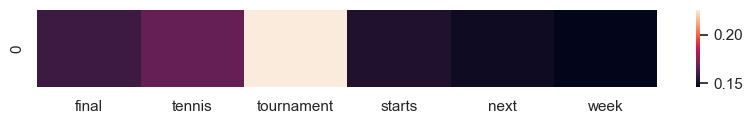

In [232]:
# Visualize a bi-gram filter's outputs
sns.set(rc={"figure.figsize":(10, 1)})
tokens = tokenizer.sequences_to_texts(X)[0].split(" ")
sns.heatmap(attn_vals, xticklabels=tokens)